In [1]:
################# imports  ################
from os import listdir
from os.path import isfile, join
import pandas as pd

from io import StringIO
from io import BytesIO
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack,vstack,QTable
from astropy.table import Table
from esutil import htm
import numpy as np
import pandas as pd
import os #biblioteca para manipular arquivos e pastas
from os import listdir
from os.path import isfile, join
import healpy as hp


In [2]:
################# Match ################

def match(cat_1, cat_2, column_1, column_2, column_3, column_4,error):
    'Function to make the matching with two tables, using the esutil'
    h = htm.HTM(depth=10)
    m1, m2, d12 = h.match(np.array(cat_1[column_1]), 
                          np.array(cat_1[column_3]),
                          np.array(cat_2[column_2]), 
                          np.array(cat_2[column_4]),
                          error, maxmatch=1)
    
    submatched = cat_1[m1]
    manmatched = cat_2[m2]
    matched = hstack([submatched, manmatched])
      
    return matched

# Carregamento dos dados 

## DES

In [3]:
################# lê e concatena todas as tabelas que tem no diretório indicado ################
diretorio = '/media/new-drive/CamilaCardoso/DES/'
table_list = []
for diretorio, subpastas, arquivos in os.walk(diretorio):
    for arquivo in arquivos:
        df = Table.read(os.path.join(diretorio, arquivo)).to_pandas()
        table_list.append(df)
        print(os.path.join(diretorio, arquivo))
des_data = pd.concat(table_list, axis=0, ignore_index=True)

/media/new-drive/CamilaCardoso/DES/DES_DR2_interval_0_1000.fits
/media/new-drive/CamilaCardoso/DES/DES_DR2_interval_1000_2000.fits
/media/new-drive/CamilaCardoso/DES/DES_DR2_interval_2000_3000.fits
/media/new-drive/CamilaCardoso/DES/DES_DR2_interval_3000_4000.fits
/media/new-drive/CamilaCardoso/DES/DES_DR2_interval_4000_5000.fits
/media/new-drive/CamilaCardoso/DES/DES_DR2_interval_5000_6000.fits
/media/new-drive/CamilaCardoso/DES/DES_DR2_interval_6000_6568.fits


## Sloan

In [4]:
diretorio = '/media/new-drive/CamilaCardoso/SLOAN'
arquivo = 'SLOAN_DR16_sloan_data_quasar_all.fits'
sloan_quasars_dr16 = Table.read(os.path.join(diretorio, arquivo))

In [5]:
################# Match ################

# Conjunto de dados 02
des_data_table = Table.from_pandas(des_data)

# Conjunto de dados 01
match_des_sloan_quasars = match(sloan_quasars_dr16,des_data_table,'ra','RA','dec','DEC',0.0002)
# 1 segundo de arco = 0.0002778 graus

In [6]:
match_des_sloan_quasars.write('/media/new-drive/CamilaCardoso/CROSS_MATCH_SLOAN_DR16_DES_20211029.fits')

## Plot

In [10]:
Nside = 64
Npix = hp.nside2npix(Nside) # Definição de Npix - 12*(Nside)**2

# Criando um dataframe para a plotagem do mollview 
pixels_location = pd.DataFrame()
pixels_location['indices'] = np.arange(Npix)

In [66]:
match_pixels_location = pd.DataFrame()
match_pixels_location['indices'] = match_des_sloan_quasars['Npix']
match_pixels_grouped = match_pixels_location.groupby(['indices']).size().reset_index(name='counts')

match_pixels_frequency = pd.merge(pixels_location, match_pixels_grouped, how = 'outer')
match_pixels_frequency = match_pixels_frequency.fillna(0) 

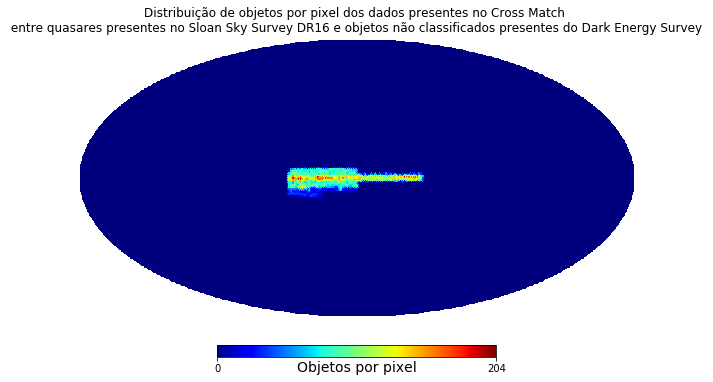

In [73]:
plt.figure(figsize=(10,10))
hp.mollview(match_pixels_frequency.counts.values, title="Distribuição de objetos por pixel dos dados presentes no Cross Match \n entre quasares presentes no Sloan Sky Survey DR16 e objetos não classificados presentes do Dark Energy Survey ", unit='Objetos por pixel', cmap='jet', hold =True )
plt.show()